In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


# Module 5: Practical - Variational Autoencoders

The images in the Fashion-MNIST dataset that we will use are 28 by 28 pixel images with pixel values normalized to be between 0 and 1. While we can design our neural network to take in 28 by 28 image, it is easier to first pad the images with zeros to obtain a 32 by 32 pixel image. Since the standard convolution layers half the size of the image, having width and height equal a power of 2 allows us to process the input through three convolution layers without any extra code.

In [2]:
# Prepare the Data

# Define custom preprocessing function
def preprocess(img):
    img = np.pad(img, ((2, 2), (2, 2)), constant_values=0.0)
    return img;

transform = transforms.Compose([transforms.Lambda(preprocess), transforms.ToTensor()])
# Alternatively
# transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████████████████| 26.4M/26.4M [00:06<00:00, 4.08MB/s]
100%|███████████████████████| 29.5k/29.5k [00:00<00:00, 128kB/s]
100%|██████████████████████| 4.42M/4.42M [00:01<00:00, 2.28MB/s]
100%|██████████████████████| 5.15k/5.15k [00:00<00:00, 9.18MB/s]


Let's look at the shape of the first image in the train dataset. As we can see the image is 32 by 32 pixels with one channel (grayscale).

In [3]:
first_image, first_label = train_dataset[0]
print(first_image.shape)


torch.Size([1, 32, 32])


Let's visualize it using `plt.imshow`. Recall that it expects the channel to be the last dimension, so we permute the image first.

Label:  9


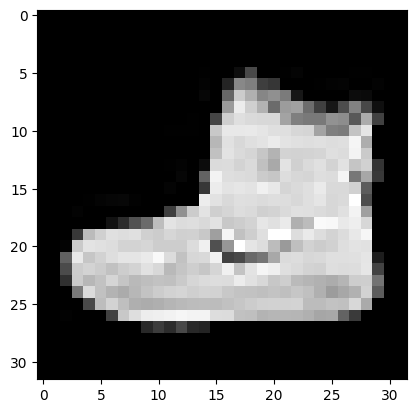

In [4]:
print("Label: ", first_label)
plt.imshow(first_image.permute(1,2,0).squeeze(), cmap='gray')
plt.show()


In [5]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
print("Length of the train dataset: ", len(train_dataset))
print("Length of list(train_loader): ", len(list(train_loader)))
print("Type of the first element of list(train_loader): ", type(list(train_loader)[0]))
print("Type of the first element of list(train_loader)[0]: ", type(list(train_loader)[0][0]))
print("Shape of the first element of list(train_loader)[0]: ", list(train_loader)[0][0].shape)


Length of the train dataset:  60000
Length of list(train_loader):  1875
Type of the first element of list(train_loader):  <class 'list'>
Type of the first element of list(train_loader)[0]:  <class 'torch.Tensor'>
Shape of the first element of list(train_loader)[0]:  torch.Size([32, 1, 32, 32])


Let's look at the first image in the first batch.

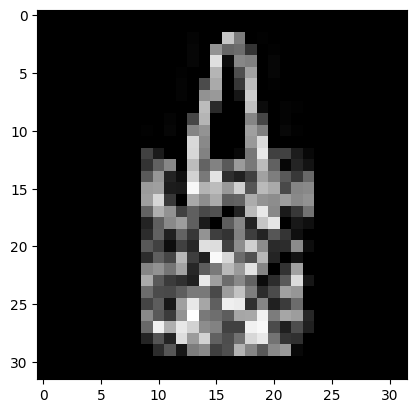

In [7]:
next_batch_images, next_batch_labels = next(iter(train_loader))
_first_img = next_batch_images[0] # retrieve the first image from the batch of 32
_first_label = next_batch_labels[0] # retrieve the first label from the batch of 32
plt.imshow(_first_img.permute(1, 2, 0), cmap='gray') # imshow requires the image to be in height x width x channels format
plt.show()


## Autoencoder Architecture

We can now define our Encoder architecture, which consists of three convolutional layers followed by a fully connected layer.

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 4 * 4, 2)  # Adjusted for input size (32,32)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.fc(x)
        return x


Similarly, the decoder architecture replaces the convolutional layers with convolutional transpose layers, which are applied after a fully connected layer, 'reversing' the operations in the encoder.

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(2, 128 * 4 * 4)
        self.convtrans1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convtrans2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convtrans3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 4, 4)
        x = F.relu(self.convtrans1(x))
        x = F.relu(self.convtrans2(x))
        x = torch.sigmoid(self.convtrans3(x))
        return x


Finally, the autoencoder forward pass simply applies the encoder followed by decoder.

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


As usual, we define the model, the optimizer, and the loss function.

In [11]:
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
loss_function = torch.nn.BCELoss()
print(autoencoder)


NameError: name 'device' is not defined

### Training the model

In [ ]:
from tqdm import tqdm

# Parameters
EPOCHS = 10

def train_model(model, optimizer, loss_function, train_loader, device, epochs=10):
    # Train the model
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        # tqdm is a nice library to use to show a progress bar for our training
        # To use it we simply replace:
        #   for data in train loader
        # with:
        train_loader_with_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for data in train_loader_with_progress:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_loader_with_progress.set_postfix(loss=f'{loss.item():.4f}')
            running_loss = 0.0

    print("Finished Training")

train_model(autoencoder, optimizer, loss_function, train_loader, device, epochs=EPOCHS)


Let's now load the first batch from the test data loader and run the autoencoder model on it.

In [ ]:
# Get first batch of images from the test dataset
example_images, _ = next(iter(test_loader))
example_images = example_images.to(device)

# Perform predictions
autoencoder.eval()
with torch.no_grad():
    predictions = autoencoder(example_images)

print("Predictions shape:", predictions.shape)


Recall that the prediction is the model's reconstruction of the input image from the latent representation generated by the encoder. Let's visualize the first reconstruction. As always, we need to move the pytorch image tensors to the cpu and convert them to numpy before we can visualize them.  Since the images are grayscale we also remove the single channel dimension using `squeeze()`

In [ ]:
original = example_images[1].cpu().squeeze().numpy()
reconstructed = predictions[1].cpu().squeeze().numpy()

# Plotting the images side by side
_fig, _axes = plt.subplots(1, 2, figsize=(8, 4))

_axes[0].imshow(original, cmap='gray')
_axes[0].set_title("Original")
_axes[0].axis('off')

_axes[1].imshow(reconstructed, cmap='gray')
_axes[1].set_title("Reconstructed")
_axes[1].axis('off')

plt.show()


We will now generate new images by first sampling in the latent space and then running the decoder.

In [ ]:
# First, generate embeddings from your test data
autoencoder.eval()
embeddings = []

# Perform predictions
autoencoder.eval()
with torch.no_grad():
    embedding = autoencoder.encoder(example_images).cpu().numpy()
    embeddings.append(embedding)

embeddings = np.concatenate(embeddings, axis=0)

# Generate random points in embedding space within the bounds of the encoded first batch of images.
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
random_samples = np.random.uniform(mins, maxs, size=(18, 2))
random_samples = torch.tensor(random_samples, dtype=torch.float32).to(device)

# Decode random samples
with torch.no_grad():
    reconstructions = autoencoder.decoder(random_samples).cpu().numpy()

# Plot reconstructed images
_fig, _axes = plt.subplots(3, 6, figsize=(12, 6))
for _i, _ax in enumerate(_axes.flat):
    _ax.imshow(reconstructions[_i].squeeze(), cmap='gray')
    _ax.axis('off')

plt.tight_layout()
plt.show()


The results are not bad, but some of the images are not very realistic. One of the reasons is that the encoder does not enforce any continuity conditions. Two points, which are very close in the latent space might not actually correspond to similar images. This issue is not too bad with a smaller dimensional embedding space, but as we move to more complicated images and higher dimensional latent representations, this will become worse - this is the 'curse of dimensionality'.  To address this, we will now implement a Variational Autoencoder (VAE) model.

## Variational Autoencoder (VAE) Architecture

The idea behind VAE is for the encoder to map to a distribution, rather than an exact latent variable. So the encoder network now outputs two vectors, the mean and the log variance of a normal distribution.
In turn, the decoder, first samples from this distribution and then uses the same decoder as before to map the sampled latent variable back to the original image space.

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar   

class VAE(nn.Module):
    def __init__(self, encoder, decoder, beta=1.0):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mu, logvar

# Example usage
encoder = VariationalEncoder()
decoder = Decoder()
vae = VAE(encoder, decoder).to(device)


We also need to slightly change the loss function.  In addition to penalizing the deviation of the reconstructed image from the original input, we penalize deviation of the normal distribution in the latent space from a standard normal distribution (mean: 0, variance 1) through the Kullback-Leibler (KL) divergence term.

In [ ]:
def train_vae_model(model, optimizer, loss_function, train_loader, device, epochs=10):
    # Train the model
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        # tqdm is a nice library to use to show a progress bar for our training
        # To use it we simply replace:
        #   for data in train loader
        # with:
        train_loader_with_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for data in train_loader_with_progress:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(inputs)
            loss = loss_function(recon, inputs, mu, logvar)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_loader_with_progress.set_postfix(loss=f'{loss.item():.4f}')
            running_loss = 0.0

    print("Finished Training")

def vae_loss_function(recon_x, x, mu, logvar):
    beta = 500
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return beta * BCE + KLD

_optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

train_vae_model(vae, _optimizer, vae_loss_function, train_loader, device, epochs=EPOCHS)


In [ ]:
import math

num_samples = 20
vae.eval()
with torch.no_grad():
    z = torch.randn(num_samples, 2).to(device)
    samples = vae.decoder(z)
    samples = samples.cpu().numpy()

_fig, _axes = plt.subplots(3, 6, figsize=(12, 6))
for _i, _ax in enumerate(_axes.flat):
    _ax.imshow(samples[_i].squeeze(), cmap='gray')
    _ax.axis('off')

plt.tight_layout()
plt.show()
